### Problem 1

#### (a)

This model is essentially the reduced random-effect model by considering: 
$$
z = \mu + e\\
\mu \sim \mathcal{N}(0, \alpha^{-1}I)\\
e\sim \mathcal{N}(0, I)
$$

The goal is maximizing the loglikelihood:
$$
\max_\alpha \log p(z;\alpha)
$$

To solve this maximization problem, we implement EM algorithm.

1\. Derive the complete-data loglikelihood:
$$
\log p(z, \mu;\alpha) = \log p(z|\mu) + \log p(\mu;\alpha)\\
= \frac{N}{2}\log \frac{1}{2\pi} -\frac{1}{2}\sum_{n=1}^N(z_n - \mu_n)^2 + \frac{N}{2}\log\frac{\alpha}{2\pi} - \frac{\alpha}{2}\mu^T\mu
$$

2\. k-th E-step:
$$
\mathbb{E}_{\mu|z; \alpha_{k-1}} \left[\log p(z, \mu;\alpha)\right] = \frac{N}{2}\log \frac{1}{2\pi}+\frac{N}{2}\log\frac{\alpha}{2\pi} - \sum_{n=1}^N \left(z_n^2 -\frac{2z_n^2}{\alpha_{k-1}\ \  +1} + \left(\frac{z_n}{\alpha_{k-1}\ \  +1}\right)^2 + \frac{1}{\alpha_{k-1}\ \  +1}\right) -\frac{\alpha}{2} \sum_{n=1}^N \left(\left(\frac{z_n}{\alpha_{k-1}\ \  +1}\right)^2+\frac{1}{\alpha_{k-1}\ \  +1}\right)
$$
where $\mu|z; \alpha_{k-1}\sim \mathcal{N}(\frac{1}{\alpha_{k-1}\ \  +1}z, \frac{1}{\alpha+1}I)$.

3\. k-th M-step:
$$
\alpha_k = \frac{N}{\sum_{n=1}^N \left(\left(\frac{z_n}{\alpha_{k-1}\ \  +1}\right)^2+\frac{1}{\alpha_{k-1}\ \  +1}\right)}
$$

When convergence, $\hat{\alpha} = \alpha_K$. Further, we obtain an estimate of $\mu$ based on posterior mean:
$$
\hat{\mu} = \frac{z}{\hat{\alpha}  +1}
$$

#### (b)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import default_rng
rng = default_rng()

from sklearn.metrics import mean_squared_error

In [2]:
class GenData:
    def __init__(self, N, alpha=1.0, seed=1):
        rng = default_rng(seed)
        mu = rng.standard_normal(N)
        std = np.sqrt(1.0/alpha)
        z = mu + rng.normal(loc=0.0, scale=std, size=N)
        self.alpha = alpha
        self.mu = mu
        self.z = z 

In [3]:
def em_estimator(z, alpha_0, time_step):
    N = len(z)
    loglikelihood = np.zeros(time_step)
    alphas = np.zeros(time_step)
    
    alphas[0] = alpha_0
    loglikelihood[0] = - N/2*np.log(2*np.pi) \
                       - N/2*np.log(1/alphas[0]+1) \
                       - 1.0/2/(1/alphas[0]+1)*np.sum(z*z)
    for k in range(1, time_step):
        alphas[k] = N/np.sum(1.0/(alphas[k-1]+1) + z*z/(alphas[k-1]+1)**2)
        loglikelihood[k] = - N/2*np.log(2*np.pi) \
                           - N/2*np.log(1/alphas[k]+1) \
                           - 1.0/2/(1/alphas[k]+1)*np.sum(z*z)
    mu_em = z/(alphas[time_step-1]+1)
    return mu_em, alphas, loglikelihood

def js_estimator(z):
    N = len(z)
    mu_js = (1.0 - (N-2)/np.sum(z*z))*z
    alpha = 1.0/(np.sum(z*z)/(N-2)-1)
    return mu_js, alpha

Test the loglikelihood of EM.

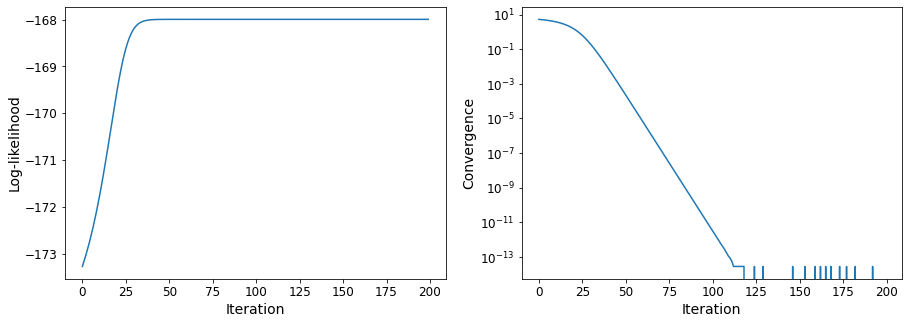

Estimated alpha =  1.4588603517175487


In [4]:
data = GenData(100, seed=1)
mu_em, alphas, llh = em_estimator(data.z, alpha_0=10, time_step=200)
fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].plot(llh)
ax[0].set_ylabel('Log-likelihood', fontsize=14)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].tick_params(labelsize=12)

ax[1].plot(max(llh)-llh)
ax[1].set_ylabel('Convergence', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].tick_params(labelsize=12)
ax[1].set_yscale('log')
plt.show()
print('Estimated alpha = ', alphas[-1])

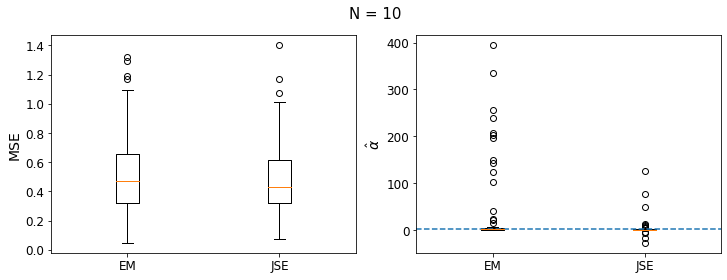

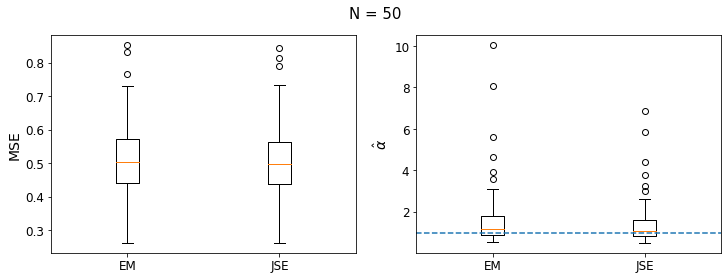

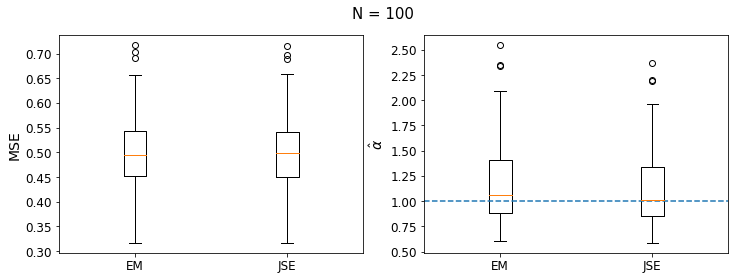

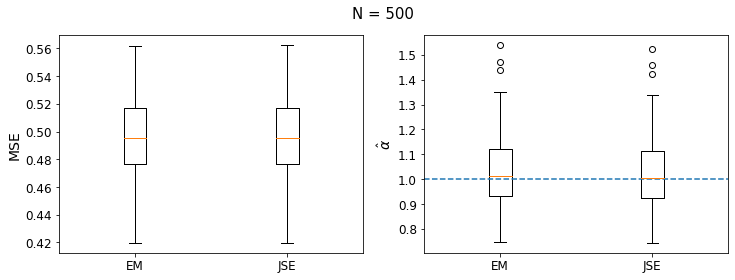

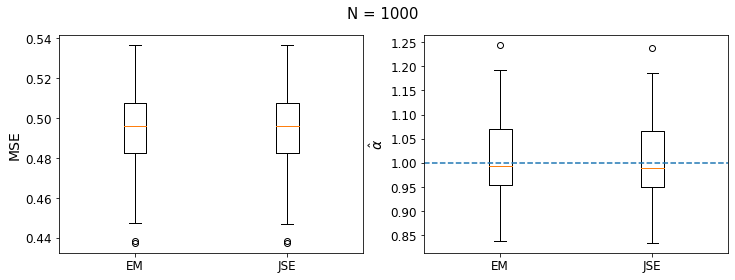

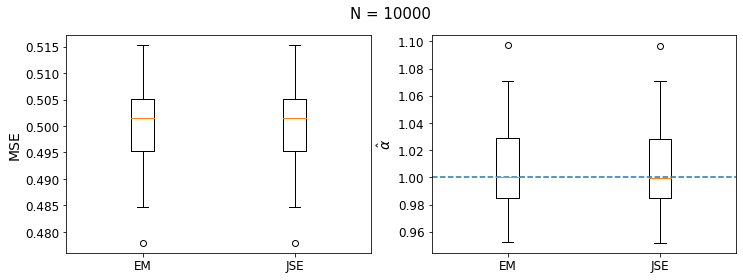

In [5]:
nrep = 100
N_list = [10, 50, 100, 500, 1000, 10000]
for (id,N) in enumerate(N_list):
    mse_em = np.zeros(nrep)
    mse_js = np.zeros(nrep)
    alpha_em = np.zeros(nrep)
    alpha_js = np.zeros(nrep)
    for n in range(nrep):
        data = GenData(N, seed=n)
        mu_em, alphas, _ = em_estimator(data.z, alpha_0=0.1, time_step=1000)
        alpha_em[n] = alphas[-1]
        mu_js, alpha = js_estimator(data.z)
        alpha_js[n] = alpha
        mse_em[n] = mean_squared_error(data.mu, mu_em)
        mse_js[n] = mean_squared_error(data.mu, mu_js)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].boxplot([mse_em, mse_js])
    ax[0].set_xticklabels(['EM', 'JSE'], fontsize=14)
    ax[0].set_ylabel('MSE', fontsize=14)
    ax[0].tick_params(labelsize=12)
 
    ax[1].boxplot([alpha_em, alpha_js])
    ax[1].axhline(1.0, linestyle='--')
    ax[1].set_xticklabels(['EM', 'JSE'], fontsize=14)
    ax[1].set_ylabel('$\hat\\alpha$', fontsize=14)
    ax[1].tick_params(labelsize=12)
    plt.suptitle(f'N = {N}', fontsize=15)
    

For James-Stein estimator, $\alpha$ is estimated as
$$
\hat{\alpha}^{-1} = \frac{\|z\|^2}{N-2} - 1, 
$$
We compare the EM algorithm and James-Stein estimator. 
+ Because in general EM algorithm is on solving a non-concave maximization problem. For small sample size with relative high variance, the objective function (log-likelihood) may have strange shape, which is far from the theoretical result. This phenomenon is shown for small sample size (N < 100). In our implementation, we use the same initial points $\alpha=0.1$ and find that EM cannot give the stable results for small sample size.
+ For large sample size, we find that both EM and JSE give almost the same and good results.